In [46]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import vdmlab as vdm

from startup import load_shortcut_position
from startup import extract_xy

In [47]:
# import info.r063d2 as info # 2 targets
import info.r066d1 as info # 3 targets
# import info.r066d5 as info # 1 target

In [48]:
dataloc = 'C:/Users/Emily/code/emi_shortcut/cache/data'

events = vdm.load_events(os.path.join(dataloc, info.event_filename[-26:]), info.event_labels)

In [49]:
def remove_jumps_to_feeder(x, y, time, info, time_thresh=1.0, jump_thresh=20, dist_thresh=5):  
    # Find those indices that have unnatural jumps in the position.
    # Remove jump points within to the feeder location. 
    # Not including jumps due to jumps in time (eg. from stopping the recording).
    
    feeder1_x = info.path_pts['feeder1'][0]
    feeder1_y = info.path_pts['feeder1'][1]
    feeder2_x = info.path_pts['feeder2'][0]
    feeder2_y = info.path_pts['feeder2'][1]
    
    while True: 
        jumps = np.append(np.array([0]), np.sqrt(np.diff(x)**2 + np.diff(y)**2))
        remove_idx = jumps > jump_thresh

        time_jumps = np.append(np.diff(time) > time_thresh, np.array([False], dtype=bool))    
        remove_idx[time_jumps] = False

        dist_feeder1 = np.sqrt((x - feeder1_x)**2 + (y - feeder1_y)**2)
        dist_feeder2 = np.sqrt((x - feeder2_x)**2 + (y - feeder2_y)**2)
        dist_feeder = np.minimum(dist_feeder1, dist_feeder2)
        dist_jumps = dist_feeder > dist_thresh
        remove_idx[dist_jumps] = False

        if np.sum(remove_idx) > 0:
            x = x[~remove_idx]
            y = y[~remove_idx]
            time = time[~remove_idx] 
        else:
            break
            
    return x, y, time


def median_filter(x, y, kernel=3):
    # Applying a median filter to the x and y positions
    
    x = signal.medfilt(x, kernel_size=kernel)
    y = signal.medfilt(y, kernel_size=kernel)
    
    return x, y

def load_shortcut_position(info, filename, events):
    """Loads and corrects shortcut position.

    Parameters
    ----------
    info: module
    filename: str
    events: dict

    Returns
    -------
    position: vdm.Position

    """
    nvt_data = vdm.load_nvt(filename)
    targets = nvt_data['targets']
    times = nvt_data['time']

    # Initialize x, y arrays
    x = np.zeros(targets.shape)
    y = np.zeros(targets.shape)
    # time = np.zeros(targets.shape)

    # X and Y are stored in a custom bitfield. See Neuralynx data file format documentation for details.
    # Briefly, each record contains up to 50 targets, each stored in 32bit field.
    # X field at [20:31] and Y at [4:15].
    for target in range(targets.shape[1]):
        this_sample = targets[:, target]
        for sample in range(targets.shape[0]):
            # When the bitfield is equal to zero there is no valid data for that field
            # and remains zero for the rest of the bitfields in the record.
            if this_sample[target] == 0:
                break
            x[sample, target], y[sample, target] = extract_xy(int(this_sample[sample]))
    
    x = x / info.scale_targets[0]
    y = y / info.scale_targets[1]

    # Remove columns with no target data
    col_idx = (np.sum(x == 0, axis=0) == x.shape[0]) & (np.sum(y == 0, axis=0) == y.shape[0])
    xs = np.array(x[:, ~col_idx])
    ys = np.array(y[:, ~col_idx])

    # Put the LED events in the same array, sorted by time
    leds = []
    leds.extend([(event, 'led1') for event in events['led1']])
    leds.extend([(event, 'led2') for event in events['led2']])
    sorted_leds = sorted(leds)

    # Get an array of feeder locations when that feeder is actively flashing
    feeder_x_location = np.zeros(xs.shape[0])
    feeder_y_location = np.zeros(ys.shape[0])

    feeder1_x = info.path_pts['feeder1'][0]
    feeder1_y = info.path_pts['feeder1'][1]
    feeder2_x = info.path_pts['feeder2'][0]
    feeder2_y = info.path_pts['feeder2'][1]

    last_label = ''

    for time, label in sorted_leds:
        if label == last_label:
            continue
        idx = vdm.find_nearest_idx(times, time)
        x_location = feeder1_x if label == 'led1' else feeder2_x
        y_location = feeder1_y if label == 'led1' else feeder2_y

        feeder_x_location[idx:] = x_location
        feeder_y_location[idx:] = y_location

        last_label = label

    # Initialize xx and yy as the first target
    xx = np.array(xs[:, 0])
    yy = np.array(ys[:, 0])
    
    plt.plot(xx, yy, 'k.', ms=1)
    plt.plot(feeder1_x, feeder1_y, 'r.', ms=10)
    plt.plot(feeder2_x, feeder2_y, 'r.', ms=10)
    plt.show()
    
    # This correction method assumes we are working with two targets
    # (eg. subtracts the two targets, averages over two targets, etc.)
    if xs.shape[1] == 1 and ys.shape[1] == 1:
        # Remove jumps to feeder location
        xx, yy, times = remove_jumps_to_feeder(xx, yy, times, info)
        
        # Apply a median filter
        xx, yy = median_filter(xx, yy)
        
        print('one target')
        position = vdm.Position(np.hstack(np.array([xx, yy])[..., np.newaxis]), times)
        dist = position[:-1].distance(position[1:])
        print('n_jumps:', np.sum(dist > 10))
        return position

    # Find indices where only one target was available
#     one_target_idx = (xs[:, 1] == 0) | (ys[:, 1] == 0)
    one_target_idx = (xs[:, 1:] == 0) | (ys[:, 1:] == 0)
    one_target_idx = np.prod(one_target_idx[..., np.newaxis], axis=1, dtype=bool)[:, 0]

    # One target is contaminated when the distance between the two targets is large   
    target_x_dist = np.var(xs, axis=1)
    target_y_dist = np.var(ys, axis=1)
    
    # Contaminated samples are using the feeder LED instead of the implant LEDs
    contamination_thresh = 5
    contaminated_idx = (target_x_dist > contamination_thresh) | (target_y_dist > contamination_thresh)

    # Non contaminated implant LED samples with targets get averaged
    idx = ~contaminated_idx & ~one_target_idx
    xx[idx] = np.mean(xs[idx], axis=1)
    yy[idx] = np.mean(ys[idx], axis=1)

    # For contaminated samples, we use the sample that is furthest from the feeder location
    feeder_x_dist = np.abs(xs - feeder_x_location[..., np.newaxis])
    feeder_y_dist = np.abs(ys - feeder_y_location[..., np.newaxis])

    feeder_dist = feeder_x_dist + feeder_y_dist
    furthest_idx = np.argmax(feeder_dist, axis=1)

    idx = contaminated_idx & ~one_target_idx
    xx[idx] = xs[idx, furthest_idx[idx]]
    yy[idx] = ys[idx, furthest_idx[idx]]

    # Remove jumps to feeder location
    xx, yy, times = remove_jumps_to_feeder(xx, yy, times, info)

    # Apply a median filter
    xx, yy = median_filter(xx, yy)

    # Construct a vdm.Position object
    position = vdm.Position(np.hstack(np.array([xx, yy])[..., np.newaxis]), times)
    
    dist = position[:-1].distance(position[1:])
    print('n_jumps:', np.sum(dist > 30))

    return position

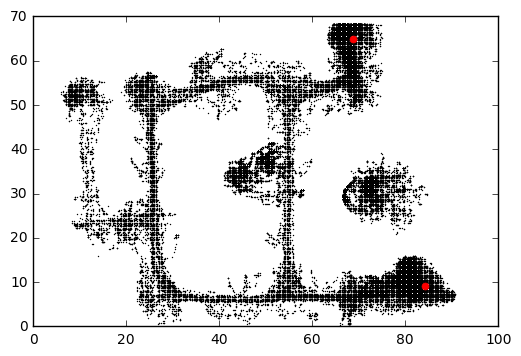

n_jumps: 23742


In [50]:
position = load_shortcut_position(info, os.path.join(dataloc, info.position_filename[-23:]), events)

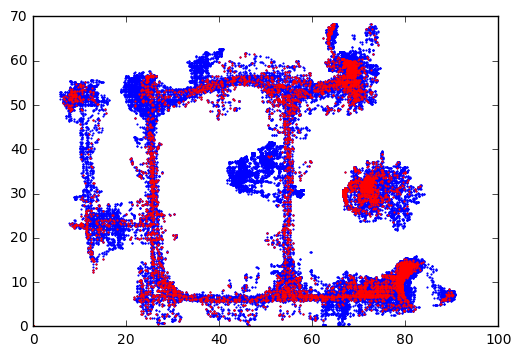

In [51]:
dist = np.append(np.array([0]), position[:-1].distance(position[1:]))
idx = dist > 10
plt.plot(position.x, position.y, 'b.', ms=2)
plt.plot(position.x[idx], position.y[idx], 'r.', ms=2)
plt.show()

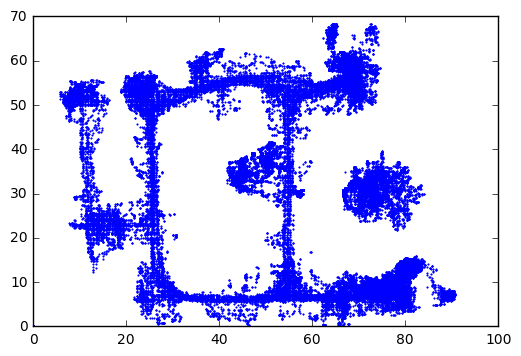

In [52]:
plt.plot(position.x, position.y, 'b.', ms=2)
plt.show()

In [ ]:
def plot_2d(position_x, position_y):
    binsize = 1
    xedges = np.arange(position_x.min(), position_x.max() + binsize, binsize)
    yedges = np.arange(position_y.min(), position_y.max() + binsize, binsize)
    xx, yy = np.meshgrid(xedges, yedges)

    position_2d, pos_xedges, pos_yedges = np.histogram2d(position_y, position_x, bins=[yedges, xedges])

    pp = plt.pcolormesh(xx, yy, position_2d, cmap='YlGn')
    plt.colorbar(pp)
    plt.show()

In [ ]:
plot_2d(position.x, position.y)